First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [1]:
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
#!pip install -r requirements.txt
#!pip install "numpy==1.26.4" "pandas==2.1.4"
#!pip install plotly
#!pip uninstall -y starvers
#!pip install plotly

In [2]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [3]:
executed_by ='stud-id_12402153'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [4]:
# group id for this project
group_id = '39'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12402153'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_11906257'  # Replace the digits after "id_" with student B's student ID

In [5]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [6]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [7]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    'qudt-unit': 'http://qudt.org/vocab/unit/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [8]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [9]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Poj" .',
f':{student_a} foaf:familyName "Netsiri" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "12402153" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "01234567"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Michael" .',
f':{student_b} foaf:familyName "Wolkerstorfer" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "11906257" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "76543210"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

In [10]:
superstore_data_path = "data"


## Business Understanding 

In [11]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [12]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
Dataset: Superstore Sales Dataset
Source: https://www.kaggle.com/datasets/vivek468/superstore-dataset-final

The dataset contains order-level retail information:
- Order/Ship Dates
- Customer, Segment, Region
- Product Category, Sub-Category
- Sales (prediction target)
- Quantity, Discount
- Profit (used only for interpretation)

Scenario:
A retail company aims to improve order-level sales forecasting. Better sales prediction supports
pricing strategy, promotion planning, and more accurate demand and inventory management.
"""

business_objectives_comment = """
Primary Business Objective:
Predict sales at the order level to strengthen revenue planning and operational decision-making.

Secondary Objectives:
- Identify key drivers of sales (e.g., category, discount, region).
- Improve pricing and promotion decisions.
- Support inventory allocation and demand planning.
- Highlight high-performing regions and product lines.
"""


business_success_criteria_comment = """
Business Success Criteria:
- Improved forecasting accuracy that reduces stockouts and overstocking.
- More informed pricing and discount decisions.
- Fewer low-value or unprofitable orders.
- Adoption of predictions in operational workflows.
"""


data_mining_goals_comment = """
Data Mining (ML) Goals:
- Build a regression model to predict Sales based on order characteristics.
- Engineer interpretable features (date fields, category aggregates).
- Avoid data leakage by excluding Profit and profit-derived attributes.
- Achieve stable generalization performance.
- Identify meaningful factors influencing sales.
"""


data_mining_success_criteria_comment = """
Data Mining Success Criteria:
- Achieve acceptable predictive performance (reasonable R² and RMSE).
- No overfitting (similar training and test results).
- Stable feature importance rankings.
- No missing-value issues or target leakage.
"""


ai_risk_aspects_comment = """
AI Risk Aspects:
1. Data Leakage:
   Profit or post-outcome information must not appear in the features.

2. Bias:
   Historical patterns may bias results toward specific regions or customer groups.

3. Over-Reliance:
   Sales depend on external factors not captured in the dataset (seasonality, supply issues).

4. Model Misuse:
   Automated discounting or pricing actions may lead to unfair treatment.

5. Explainability:
   Transparent reasoning is necessary for stakeholder trust; use interpretable features
   and feature importance methods.
"""


bu_ass_uuid_executor = "bb6a40f9-9d92-4f9f-bbd2-b65ef6a82da2" # Generate once
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

The following pseudo-code & pseudo-documentation may be used as a hint.

In [13]:
## Each Activity that follows is part of the Data Understanding Phase

data_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(data_understanding_phase_executor, prefixes=prefixes)


**load data from csv file.**

In [14]:
superstore_data_path = "data"

load_superstore_data_code_writer = student_a
def load_superstore_data()-> pd.DataFrame:

    ### Load data
    input_file = os.path.join(superstore_data_path, 'Superstore.csv')
    raw_data  = pd.read_csv(input_file, encoding="latin1", sep=',', header = 0)

    raw_data ["Order Date"] = pd.to_datetime(raw_data["Order Date"], errors="coerce")
    raw_data ["Ship Date"] = pd.to_datetime(raw_data["Ship Date"], errors="coerce")

    loaded_data = raw_data
    return loaded_data 

start_time_ld = now()
data = load_superstore_data()
end_time_ld = now()

display(data.head())

#############################################
# Documentation
#############################################

# Now document the raw data and the loaded data using appropriate ontologies.

# Always add these triples for every activity to define the executor!
ld_ass_uuid_executor = "b8bac193-c4e6-4e31-9134-b23e001e279c" # Generate once
load_superstore_data_executor = [
    f':load_superstore_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(load_superstore_data_executor, prefixes=prefixes)

ld_ass_uuid_writer = "c600e15c-87a9-4e2a-be85-b6c2a3014210" # Generate once
ld_report = """
Load all superstore data and convert order date and ship date to datetime. 
"""
load_superstore_data_activity = [
    ':load_superstore_data rdf:type prov:Activity .',
    ':load_superstore_data sc:isPartOf :data_understanding_phase .',
    ':load_superstore_data rdfs:comment \'Data Understanding\' .',
    f':load_superstore_data rdfs:comment """{ld_report}""" .', 
    f':load_superstore_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_superstore_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    f':load_superstore_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_superstore_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # INPUT of activity
    ':load_superstore_data prov:used :superstore_csv .',
    ':superstore_csv rdf:type prov:Entity .',
    ':superstore_csv prov:wasDerivedFrom :superstore_data_path .',
    ':superstore_data_path rdf:type prov:Entity .',
    ':raw_data rdf:type prov:Entity .',
    ':raw_data prov:wasDerivedFrom :superstore_csv .',
    # OUTPUT of activity
    ':data rdf:type prov:Entity .',
    ':data prov:wasGeneratedBy :load_superstore_data .',
    ':data prov:wasDerivedFrom :raw_data .',
]
engine.insert(load_superstore_data_activity, prefixes=prefixes)

# Further descibe the raw data using Croissant

raw_data_triples = [
    # Dataset-level description
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data sc:name "Superstore Sales Dataset" .',
    ':raw_data sc:description "Order-level retail sales transactions from a superstore." .',
    # Distribution: the CSV file
    ':superstore_csv rdf:type cr:FileObject .',
    ':superstore_csv sc:name "Superstore.csv" .',
    ':superstore_csv sc:encodingFormat "text/csv" .',
    ':raw_data sc:distribution :superstore_csv .',
    # RecordSet describing the tabular structure
    ':raw_recordset rdf:type cr:RecordSet .',
    ':raw_recordset sc:name "Superstore order table" .',
    ':raw_recordset sc:description "Table of order-level retail transactions with customer, product, and sales information." .',
    ':raw_recordset cr:source :superstore_csv .',
    ':raw_data cr:recordSet :raw_recordset .',
    # Row ID (integer)
    ':raw_recordset cr:field :field_row_id .',
    ':field_row_id rdf:type cr:Field .',
    ':field_row_id sc:name "Row ID" .',
    ':field_row_id sc:description "Unique row identifier for each record." .',
    ':field_row_id cr:dataType xsd:integer .',
    # Order ID (string)
    ':raw_recordset cr:field :field_order_id .',
    ':field_order_id rdf:type cr:Field .',
    ':field_order_id sc:name "Order ID" .',
    ':field_order_id sc:description "Identifier of the customer order." .',
    ':field_order_id cr:dataType xsd:string .',
    # Order Date (date)
    ':raw_recordset cr:field :field_order_date .',
    ':field_order_date rdf:type cr:Field .',
    ':field_order_date sc:name "Order Date" .',
    ':field_order_date sc:description "Date when the order was placed." .',
    ':field_order_date cr:dataType xsd:date .',
    # Ship Date (date)
    ':raw_recordset cr:field :field_ship_date .',
    ':field_ship_date rdf:type cr:Field .',
    ':field_ship_date sc:name "Ship Date" .',
    ':field_ship_date sc:description "Date when the order was shipped." .',
    ':field_ship_date cr:dataType xsd:date .',
    # Ship Mode (string)
    ':raw_recordset cr:field :field_ship_mode .',
    ':field_ship_mode rdf:type cr:Field .',
    ':field_ship_mode sc:name "Ship Mode" .',
    ':field_ship_mode sc:description "Shipping service level (e.g., Second Class, Standard Class)." .',
    ':field_ship_mode cr:dataType xsd:string .',
    # Customer ID (string)
    ':raw_recordset cr:field :field_customer_id .',
    ':field_customer_id rdf:type cr:Field .',
    ':field_customer_id sc:name "Customer ID" .',
    ':field_customer_id sc:description "Identifier of the customer placing the order." .',
    ':field_customer_id cr:dataType xsd:string .',
    # Customer Name (string)
    ':raw_recordset cr:field :field_customer_name .',
    ':field_customer_name rdf:type cr:Field .',
    ':field_customer_name sc:name "Customer Name" .',
    ':field_customer_name sc:description "Full name of the customer." .',
    ':field_customer_name cr:dataType xsd:string .',
    # Segment (string)
    ':raw_recordset cr:field :field_segment .',
    ':field_segment rdf:type cr:Field .',
    ':field_segment sc:name "Segment" .',
    ':field_segment sc:description "Customer segment (Consumer, Corporate, Home Office)." .',
    ':field_segment cr:dataType xsd:string .',
    # Country (string)
    ':raw_recordset cr:field :field_country .',
    ':field_country rdf:type cr:Field .',
    ':field_country sc:name "Country" .',
    ':field_country sc:description "Country where the order was placed." .',
    ':field_country cr:dataType xsd:string .',
    # City (string)
    ':raw_recordset cr:field :field_city .',
    ':field_city rdf:type cr:Field .',
    ':field_city sc:name "City" .',
    ':field_city sc:description "City of the shipping address." .',
    ':field_city cr:dataType xsd:string .',
    # State (string)
    ':raw_recordset cr:field :field_state .',
    ':field_state rdf:type cr:Field .',
    ':field_state sc:name "State" .',
    ':field_state sc:description "State of the shipping address." .',
    ':field_state cr:dataType xsd:string .',
    # Zip Code (string)
    ':raw_recordset cr:field :field_postal_code .',
    ':field_postal_code rdf:type cr:Field .',
    ':field_postal_code sc:name "Postal Code" .',
    ':field_postal_code sc:description "ZIP code of the shipping address." .',
    ':field_postal_code cr:dataType xsd:string .',
    # Region (string)
    ':raw_recordset cr:field :field_region .',
    ':field_region rdf:type cr:Field .',
    ':field_region sc:name "Region" .',
    ':field_region sc:description "Geographical sales region." .',
    ':field_region cr:dataType xsd:string .',
    # Product ID (string)
    ':raw_recordset cr:field :field_product_id .',
    ':field_product_id rdf:type cr:Field .',
    ':field_product_id sc:name "Product ID" .',
    ':field_product_id sc:description "Identifier of the purchased product." .',
    ':field_product_id cr:dataType xsd:string .',
    # Category (string)
    ':raw_recordset cr:field :field_category .',
    ':field_category rdf:type cr:Field .',
    ':field_category sc:name "Category" .',
    ':field_category sc:description "Product category." .',
    ':field_category cr:dataType xsd:string .',
    # Sub-Category (string)
    ':raw_recordset cr:field :field_sub_category .',
    ':field_sub_category rdf:type cr:Field .',
    ':field_sub_category sc:name "Sub-Category" .',
    ':field_sub_category sc:description "Product sub-category." .',
    ':field_sub_category cr:dataType xsd:string .',
    # Product Name (string)
    ':raw_recordset cr:field :field_product_name .',
    ':field_product_name rdf:type cr:Field .',
    ':field_product_name sc:name "Product Name" .',
    ':field_product_name sc:description "Name of the product." .',
    ':field_product_name cr:dataType xsd:string .',
    # Sales (double)
    ':raw_recordset cr:field :field_sales .',
    ':field_sales rdf:type cr:Field .',
    ':field_sales sc:name "Sales" .',
    ':field_sales sc:description "Total sales amount per item in the order." .',
    ':field_sales cr:dataType xsd:double .',
    # Quantity (integer)
    ':raw_recordset cr:field :field_quantity .',
    ':field_quantity rdf:type cr:Field .',
    ':field_quantity sc:name "Quantity" .',
    ':field_quantity sc:description "Number of units sold." .',
    ':field_quantity cr:dataType xsd:integer .',
    # Discount (double)
    ':raw_recordset cr:field :field_discount .',
    ':field_discount rdf:type cr:Field .',
    ':field_discount sc:name "Discount" .',
    ':field_discount sc:description "Discount fraction applied to the item." .',
    ':field_discount cr:dataType xsd:double .',
    # Profit (double)
    ':raw_recordset cr:field :field_profit .',
    ':field_profit rdf:type cr:Field .',
    ':field_profit sc:name "Profit" .',
    ':field_profit sc:description "Profit for the item (Sales minus cost)." .',
    ':field_profit cr:dataType xsd:double .',
]

engine.insert(raw_data_triples, prefixes=prefixes)

# The output of the load activity is a dataset that can be described with Croissant
data_triples = [
    # Loaded dataset
    ':data rdf:type sc:Dataset .',
    ':data sc:name "Loaded Superstore Sales Dataset" .',
    ':data sc:description "Order-level retail dataset after loading Superstore.csv and parsing order and ship dates." .',
    # RecordSet for the in-memory table
    ':recordset rdf:type cr:RecordSet .',
    ':recordset sc:name "Loaded Superstore order table" .',
    ':recordset sc:description "In-memory table of order-level retail transactions with parsed date fields and derived features." .',
    ':data cr:recordSet :recordset .',
    # Reuse fields defined for :raw_data by attaching them to :recordset
    ':recordset cr:field :field_row_id .',
    ':recordset cr:field :field_order_id .',
    ':recordset cr:field :field_order_date .',
    ':recordset cr:field :field_ship_date .',
    ':recordset cr:field :field_ship_mode .',
    ':recordset cr:field :field_customer_id .',
    ':recordset cr:field :field_customer_name .',
    ':recordset cr:field :field_segment .',
    ':recordset cr:field :field_country .',
    ':recordset cr:field :field_city .',
    ':recordset cr:field :field_state .',
    ':recordset cr:field :field_postal_code .',
    ':recordset cr:field :field_region .',
    ':recordset cr:field :field_product_id .',
    ':recordset cr:field :field_category .',
    ':recordset cr:field :field_sub_category .',
    ':recordset cr:field :field_product_name .',
    ':recordset cr:field :field_sales .',
    ':recordset cr:field :field_quantity .',
    ':recordset cr:field :field_discount .',
    ':recordset cr:field :field_profit .',
    # Additional derived field in the loaded data
    ':recordset cr:field :field_day_of_week .',
    ':field_day_of_week rdf:type cr:Field .',
    ':field_day_of_week sc:name "day_of_week" .',
    ':field_day_of_week sc:description "Day of the week derived from the order date (e.g., Monday, Tuesday)." .',
    ':field_day_of_week cr:dataType xsd:string .',
    # Extra field for units demonstration (not in dataframe)
    ':recordset cr:field :field_temp .',
    ':field_temp rdf:type cr:Field .',
    ':field_temp sc:name "temperature" .',
    ':field_temp sc:description "Example temperature field used to demonstrate unit annotations." .',
    ':field_temp cr:dataType xsd:double .',
]

engine.insert(data_triples, prefixes=prefixes)

# Also add the units to the fields
units_triples = [
    # Quantity is count of items ("each")
    ':field_quantity qudt:unit qudt-unit:EA .',
    # Sales and Profit are U.S. dollars
    ':field_sales qudt:unit qudt-unit:USD .',
    ':field_profit qudt:unit qudt-unit:USD .',
]

engine.insert(units_triples, prefixes=prefixes)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


**Check outliers.**

In [16]:
check_outliers_code_writer = student_a

def check_outliers(data: pd.DataFrame, threshold=3.0, columns=('Sales', 'Quantity', 'Discount', 'Profit')) -> dict:
    results = {}

    tmp = data.copy().reset_index(drop=True)

    for col in columns:
        
        values = tmp[col].astype(float)

        mean = values.mean()
        std = values.std()

        if std == 0 or np.isnan(std):
            results[col] = []
            continue

        z_scores = (values - mean) / std

        mask = np.abs(z_scores) > threshold
        outliers = values[mask].index

        outlier_info = [
            {
                'index': int(idx),
                'z_score': float(z_scores.loc[idx])
            }
            for idx in outliers
        ]

        results[col] = outlier_info

    return results

start_time_co = now()
outliers_report = check_outliers(data, threshold=2.2)
end_time_co = now()

start_time_ho = now()
print(outliers_report)
end_time_ho = now()


#############################################
# Documentation
#############################################

# 1. Activity: Checking for outliers and creating the report
co_ass_uuid_executor = "15085e9d-15f1-4727-9b6e-776dd07fcd08"
check_outliers_executor = [
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_outliers_executor, prefixes=prefixes)

co_ass_uuid_writer = "cd4970df-9f40-4bb1-8fad-e4dc4fcdd284"
co_comment = """
Identifying outliers in the numeric columns Sales, Quantity, Discount, and Profit using a z-score approach. 
For each of these columns, all rows with an absolute z-score higher than 2.2 are reported as outliers.
This low threshold is intentionally chosen for demonstration purposes to ensure that some outliers are found.
"""
check_outliers_activity = [
    ':check_outliers rdf:type prov:Activity .',
    ':check_outliers sc:isPartOf :data_understanding_phase .',
    ':check_outliers rdfs:comment \'Data Understanding\' .',
    f':check_outliers rdfs:comment """{co_comment}""" .', 
    f':check_outliers prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{check_outliers_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_outliers prov:used :data .',
    ':outlier_report rdf:type prov:Entity .',
    f':outlier_report rdfs:comment """{str(outliers_report)}""" .',
    ':outlier_report prov:wasGeneratedBy :check_outliers .',
]
engine.insert(check_outliers_activity, prefixes=prefixes)

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = "6eaa2c0a-e592-4d85-b37f-d695844910cf"
ior_comment = """
After inspecting the outlier report for the Sales, Quantity, Discount, and Profit columns, the decision has been
made, for demonstration purposes, to remove all rows that were flagged as outliers.
"""
inspect_outlier_report_executor = student_a
inspect_outlier_report_activity = [
    ':inspect_outlier_report sc:isPartOf :data_understanding_phase .',
    ':inspect_outlier_report rdf:type prov:Activity .',
    ':inspect_outlier_report rdfs:comment \'Data Understanding\' .',
    f':inspect_outlier_report rdfs:comment """{ior_comment}""" .', 
    f':inspect_outlier_report prov:startedAtTime "{start_time_ho}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:endedAtTime "{end_time_ho}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_outlier_report_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_outlier_report prov:used :outlier_report .',
    ':outlier_decision rdf:type prov:Entity .',
    f':outlier_decision rdfs:comment """Removing all outliers for demonstration purposes.""" .',
    ':outlier_decision prov:wasGeneratedBy :inspect_outlier_report .',
]
engine.insert(inspect_outlier_report_activity, prefixes=prefixes)

{'Sales': [{'index': 10, 'z_score': 2.3687727315698957}, {'index': 27, 'z_score': 4.578571089994082}, {'index': 149, 'z_score': 2.7629290591519338}, {'index': 165, 'z_score': 12.723876999108555}, {'index': 167, 'z_score': 2.4231269494728536}, {'index': 244, 'z_score': 2.8431864088834837}, {'index': 251, 'z_score': 5.002064190516777}, {'index': 262, 'z_score': 4.540948652239076}, {'index': 263, 'z_score': 3.674477340135311}, {'index': 318, 'z_score': 6.036344282688993}, {'index': 353, 'z_score': 6.619081314562285}, {'index': 392, 'z_score': 2.5192528555587623}, {'index': 399, 'z_score': 3.476012242055848}, {'index': 487, 'z_score': 4.021040834695814}, {'index': 509, 'z_score': 9.827741917538251}, {'index': 515, 'z_score': 4.444626996519676}, {'index': 683, 'z_score': 12.46720109444531}, {'index': 721, 'z_score': 2.2833424570975516}, {'index': 806, 'z_score': 2.8144786019783083}, {'index': 910, 'z_score': 2.7259291694116397}, {'index': 949, 'z_score': 2.945008308402959}, {'index': 977, '

**Check distribution and skewness.**

In [18]:
check_distribution_code_writer = student_a

def check_distribution_and_skewness(data: pd.DataFrame, columns=('Sales', 'Quantity', 'Discount', 'Profit')) -> dict:

    results = {}

    tmp = data.copy().reset_index(drop=True)

    for col in columns:
        
        values = tmp[col].astype(float)

        stats = {
            "count": int(values.count()),
            "mean": float(values.mean()),
            "median": float(values.median()),
            "std": float(values.std()),
            "min": float(values.min()),
            "max": float(values.max()),
            "skewness": float(values.skew())  # Pearson moment skewness
        }

        results[col] = stats

    return results

start_time_dist = now()
distribution_report = check_distribution_and_skewness(data)
end_time_dist = now()

start_time_dist_print = now()
print(distribution_report)
end_time_dist_print = now()


#############################################
# Documentation
#############################################

# 1. Activity: computing distribution and skewness and creating the report
dist_ass_uuid_executor = "5f5b5b74-9c2a-4b7d-a5ef-6f9f1c2b1c11"  # Generate once
check_distribution_executor = [
    f':check_distribution prov:qualifiedAssociation :{dist_ass_uuid_executor} .',
    f':{dist_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{dist_ass_uuid_executor} rdf:type prov:Association .',
    f':{dist_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_distribution_executor, prefixes=prefixes)

dist_ass_uuid_writer = "1c4f0b1b-4b44-4b63-94fd-1f9f6a3e67c2"  # Generate once
dist_comment = """
Analyzing the distribution and skewness of Sales, Quantity, Discount, and Profit. 
For each of these columns, count, mean, median, standard deviation, min, max, and Pearson skewness are computed. 
The goal is to understand distribution shape and potential issues such as high skewness.
"""

check_distribution_activity = [
    ':check_distribution rdf:type prov:Activity .',
    ':check_distribution sc:isPartOf :data_understanding_phase .',
    ':check_distribution rdfs:comment "Data Understanding" .',
    f':check_distribution rdfs:comment """{dist_comment}""" .',
    f':check_distribution prov:startedAtTime "{start_time_dist}"^^xsd:dateTime .',
    f':check_distribution prov:endedAtTime "{end_time_dist}"^^xsd:dateTime .',
    f':check_distribution prov:qualifiedAssociation :{dist_ass_uuid_writer} .',
    f':{dist_ass_uuid_writer} prov:agent :{check_distribution_code_writer} .',
    f':{dist_ass_uuid_writer} rdf:type prov:Association .',
    f':{dist_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # Input of activity
    ':check_distribution prov:used :data .',
    # Output: the distribution report as an entity
    ':distribution_report rdf:type prov:Entity .',
    
    f':distribution_report rdfs:comment """{str(distribution_report)}""" .',
    ':distribution_report prov:wasGeneratedBy :check_distribution .',
]
engine.insert(check_distribution_activity, prefixes=prefixes)


# 2. Activity: inspecting the distribution report and deciding what to do (optional, but parallels your outlier example)

idr_ass_uuid_executor = "7c3df53e-9f57-4cdf-9cc2-7e3fb3a3a8fc"  # Generate once
idr_comment = """
After inspecting the distribution report for Sales, Quantity, Discount, and Profit, decisions can be made about
potential transformations (e.g., log-transforming highly skewed Sales or capping extreme discounts).
"""

inspect_distribution_report_executor = student_a
inspect_distribution_report_activity = [
    ':inspect_distribution_report rdf:type prov:Activity .',
    ':inspect_distribution_report sc:isPartOf :data_understanding_phase .',
    ':inspect_distribution_report rdfs:comment "Data Understanding" .',
    f':inspect_distribution_report rdfs:comment """{idr_comment}""" .',
    f':inspect_distribution_report prov:startedAtTime "{start_time_dist_print}"^^xsd:dateTime .',
    f':inspect_distribution_report prov:endedAtTime "{end_time_dist_print}"^^xsd:dateTime .',
    f':inspect_distribution_report prov:qualifiedAssociation :{idr_ass_uuid_executor} .',
    f':{idr_ass_uuid_executor} prov:agent :{inspect_distribution_report_executor} .',
    f':{idr_ass_uuid_executor} rdf:type prov:Association .',
    f':{idr_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_distribution_report prov:used :distribution_report .',
    ':distribution_decision rdf:type prov:Entity .',
    f':distribution_decision rdfs:comment """Recording potential need for transformations based on the observed skewness in Sales, Quantity, Discount, and Profit.""" .',
    ':distribution_decision prov:wasGeneratedBy :inspect_distribution_report .',
]
engine.insert(inspect_distribution_report_activity, prefixes=prefixes)

{'Sales': {'count': 9994, 'mean': 229.85800083049833, 'median': 54.489999999999995, 'std': 623.2451005086807, 'min': 0.444, 'max': 22638.48, 'skewness': 12.97275234181623}, 'Quantity': {'count': 9994, 'mean': 3.789573744246548, 'median': 3.0, 'std': 2.2251096911414, 'min': 1.0, 'max': 14.0, 'skewness': 1.2785447527223421}, 'Discount': {'count': 9994, 'mean': 0.15620272163297977, 'median': 0.2, 'std': 0.20645196782571615, 'min': 0.0, 'max': 0.8, 'skewness': 1.6842947474238648}, 'Profit': {'count': 9994, 'mean': 28.65689630778467, 'median': 8.6665, 'std': 234.2601076909573, 'min': -6599.978, 'max': 8399.976, 'skewness': 7.561431562468343}}


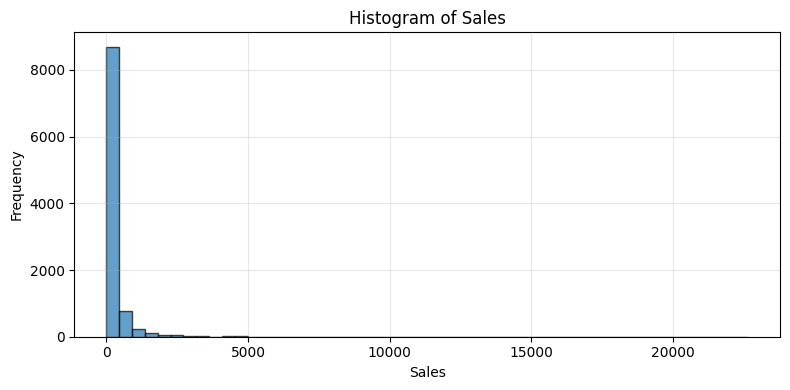

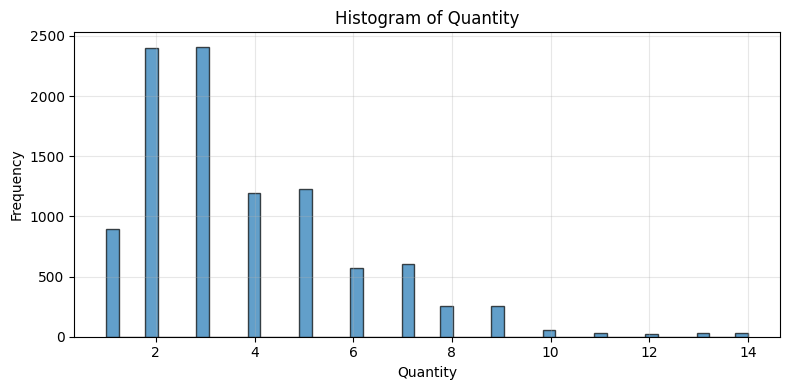

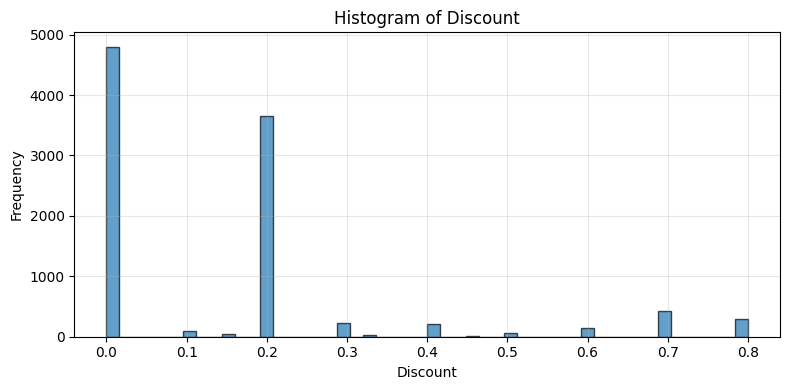

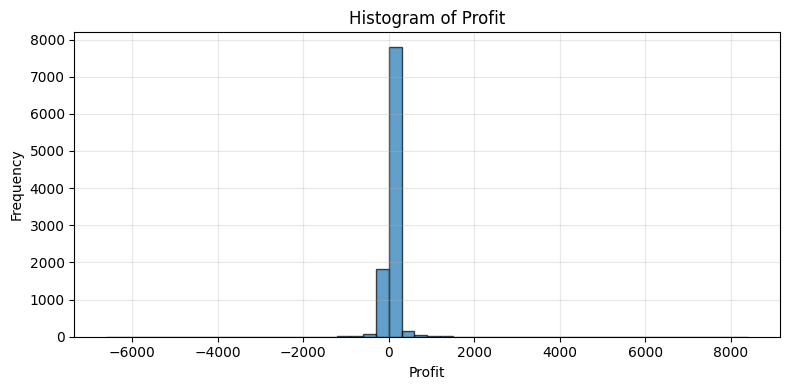

In [19]:
def plot_histograms(
    data: pd.DataFrame,
    columns=('Sales', 'Quantity', 'Discount', 'Profit'),
    bins=50
):
    """
    Plots histograms for the selected numeric columns.
    """
    for col in columns:
        if col not in data.columns:
            print(f"Skipping missing column: {col}")
            continue

        values = data[col].astype(float)

        plt.figure(figsize=(8, 4))
        plt.hist(values, bins=bins, alpha=0.7, edgecolor='black')
        plt.title(f"Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

plot_histograms(data)

**Check distribution and skewness.**

In [20]:
completeness_code_writer = student_a

def check_completeness(data: pd.DataFrame, columns=None) -> dict:

    results = {}

    tmp = data.copy()
    n_rows = len(tmp)

    # If no columns specified, use all
    if columns is None:
        columns = list(tmp.columns)

    # Column-level completeness
    column_stats = {}
    for col in columns:

        missing_count = int(tmp[col].isna().sum())
        non_missing_count = n_rows - missing_count
        missing_pct = (missing_count / n_rows * 100.0) if n_rows > 0 else 0.0

        column_stats[col] = {
            "total_rows": n_rows,
            "missing_count": missing_count,
            "non_missing_count": non_missing_count,
            "missing_pct": missing_pct,
        }

    results["column_completeness"] = column_stats

    # Row-level completeness
    rows_with_any_missing = int(tmp.isna().any(axis=1).sum())
    rows_with_no_missing = n_rows - rows_with_any_missing

    if tmp.shape[1] > 0:
        rows_gt_50pct_missing = int(
            (tmp.isna().sum(axis=1) / tmp.shape[1] > 0.5).sum()
        )
    else:
        rows_gt_50pct_missing = 0

    results["row_completeness"] = {
        "total_rows": n_rows,
        "rows_with_any_missing": rows_with_any_missing,
        "rows_with_no_missing": rows_with_no_missing,
        "rows_with_any_missing_pct": (rows_with_any_missing / n_rows * 100.0)
                                      if n_rows > 0 else 0.0,
        "rows_gt_50pct_missing": rows_gt_50pct_missing,
    }

    return results


start_time_comp = now()
completeness_report = check_completeness(data)
end_time_comp = now()

start_time_comp_print = now()
print(completeness_report)   
end_time_comp_print = now()

#############################################
# Documentation
#############################################

# 1. Activity: Checking completeness and generating the report
comp_ass_uuid_executor = "a3f6f932-6cf4-4e8a-9d07-2cf14f27b2ad"
check_completeness_executor = [
    f':check_completeness prov:qualifiedAssociation :{comp_ass_uuid_executor} .',
    f':{comp_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{comp_ass_uuid_executor} rdf:type prov:Association .',
    f':{comp_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_completeness_executor, prefixes=prefixes)

comp_ass_uuid_writer = "f17a4f86-5f2b-4e3a-9bde-81a32fdbde4a"
comp_comment = """
Analyzing completeness and missing data patterns in the dataset. For each column, total rows, missing values,
non-missing values, and percent missing are computed. Row-level missingness is also summarized.
"""

check_completeness_activity = [
    ':check_completeness rdf:type prov:Activity .',
    ':check_completeness sc:isPartOf :data_understanding_phase .',
    ':check_completeness rdfs:comment "Data Understanding" .',
    f':check_completeness rdfs:comment """{comp_comment}""" .',
    f':check_completeness prov:startedAtTime "{start_time_comp}"^^xsd:dateTime .',
    f':check_completeness prov:endedAtTime "{end_time_comp}"^^xsd:dateTime .',
    f':check_completeness prov:qualifiedAssociation :{comp_ass_uuid_writer} .',
    f':{comp_ass_uuid_writer} prov:agent :{completeness_code_writer} .',
    f':{comp_ass_uuid_writer} rdf:type prov:Association .',
    f':{comp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_completeness prov:used :data .',
    # Output entity
    ':completeness_report rdf:type prov:Entity .',
    f':completeness_report rdfs:comment """{completeness_report}""" .',  
    ':completeness_report prov:wasGeneratedBy :check_completeness .',
]
engine.insert(check_completeness_activity, prefixes=prefixes)


# 2. Activity: Inspecting completeness report and deciding next steps
icr_ass_uuid_executor = "d84f7ab1-0b0c-4b72-9ef8-456bb07ebd7f"
icr_comment = """
After inspecting the completeness report, potential next steps include dropping rows with many missing values,
imputing selected columns, or excluding attributes with excessive missingness.
"""

inspect_completeness_report_executor = student_a
inspect_completeness_report_activity = [
    ':inspect_completeness_report rdf:type prov:Activity .',
    ':inspect_completeness_report sc:isPartOf :data_understanding_phase .',
    ':inspect_completeness_report rdfs:comment "Data Understanding" .',
    f':inspect_completeness_report rdfs:comment """{icr_comment}""" .',
    f':inspect_completeness_report prov:startedAtTime "{start_time_comp_print}"^^xsd:dateTime .',
    f':inspect_completeness_report prov:endedAtTime "{end_time_comp_print}"^^xsd:dateTime .',
    f':inspect_completeness_report prov:qualifiedAssociation :{icr_ass_uuid_executor} .',
    f':{icr_ass_uuid_executor} prov:agent :{inspect_completeness_report_executor} .',
    f':{icr_ass_uuid_executor} rdf:type prov:Association .',
    f':{icr_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_completeness_report prov:used :completeness_report .',
    ':completeness_decision rdf:type prov:Entity .',
    ':completeness_decision rdfs:comment "Recording initial missing-data handling considerations." .',
    ':completeness_decision prov:wasGeneratedBy :inspect_completeness_report .',
]
engine.insert(inspect_completeness_report_activity, prefixes=prefixes)


{'column_completeness': {'Row ID': {'total_rows': 9994, 'missing_count': 0, 'non_missing_count': 9994, 'missing_pct': 0.0}, 'Order ID': {'total_rows': 9994, 'missing_count': 0, 'non_missing_count': 9994, 'missing_pct': 0.0}, 'Order Date': {'total_rows': 9994, 'missing_count': 0, 'non_missing_count': 9994, 'missing_pct': 0.0}, 'Ship Date': {'total_rows': 9994, 'missing_count': 0, 'non_missing_count': 9994, 'missing_pct': 0.0}, 'Ship Mode': {'total_rows': 9994, 'missing_count': 0, 'non_missing_count': 9994, 'missing_pct': 0.0}, 'Customer ID': {'total_rows': 9994, 'missing_count': 0, 'non_missing_count': 9994, 'missing_pct': 0.0}, 'Customer Name': {'total_rows': 9994, 'missing_count': 0, 'non_missing_count': 9994, 'missing_pct': 0.0}, 'Segment': {'total_rows': 9994, 'missing_count': 0, 'non_missing_count': 9994, 'missing_pct': 0.0}, 'Country': {'total_rows': 9994, 'missing_count': 0, 'non_missing_count': 9994, 'missing_pct': 0.0}, 'City': {'total_rows': 9994, 'missing_count': 0, 'non_miss

**Check correlation between variables.**

In [21]:
correlation_code_writer = student_a

def check_correlations(data: pd.DataFrame,columns=('Sales', 'Quantity', 'Discount', 'Profit')) -> dict:

    results = {}

    tmp = data.copy().reset_index(drop=True)

    # Keep only columns that exist
    existing_cols = [c for c in columns if c in tmp.columns]

    # Restrict to numeric version of those columns
    numeric_df = tmp[existing_cols].astype(float)

    # Compute Pearson correlation matrix
    corr_matrix = numeric_df.corr(method='pearson')

    # Convert to nested dict: {col1: {col2: value, ...}, ...}
    results["columns"] = existing_cols
    results["correlation_matrix"] = corr_matrix.to_dict()

    return results


start_time_corr = now()
correlation_report = check_correlations(data)
end_time_corr = now()

start_time_corr_print = now()
print(correlation_report)  
end_time_corr_print = now()


#############################################
# Documentation
#############################################

# 1. Activity: computing correlations and creating the report
corr_ass_uuid_executor = "b3ec8d41-1505-4d9e-9c26-0b7c7af52c11"  # Generate once
check_correlations_executor = [
    f':check_correlations prov:qualifiedAssociation :{corr_ass_uuid_executor} .',
    f':{corr_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{corr_ass_uuid_executor} rdf:type prov:Association .',
    f':{corr_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_correlations_executor, prefixes=prefixes)

corr_ass_uuid_writer = "0a1dc15d-6b0f-4bff-9f65-0ee26c2c06e3"  # Generate once
corr_comment = """
Analyzing linear relationships between the numeric variables Sales, Quantity, Discount, and Profit using
Pearson correlation. The resulting correlation matrix helps to understand how strongly these variables
co-vary, e.g., negative correlation between Discount and Profit or positive correlation between Sales and Profit.
"""

check_correlations_activity = [
    ':check_correlations rdf:type prov:Activity .',
    ':check_correlations sc:isPartOf :data_understanding_phase .',
    ':check_correlations rdfs:comment "Data Understanding" .',
    f':check_correlations rdfs:comment """{corr_comment}""" .',
    f':check_correlations prov:startedAtTime "{start_time_corr}"^^xsd:dateTime .',
    f':check_correlations prov:endedAtTime "{end_time_corr}"^^xsd:dateTime .',
    f':check_correlations prov:qualifiedAssociation :{corr_ass_uuid_writer} .',
    f':{corr_ass_uuid_writer} prov:agent :{correlation_code_writer} .',
    f':{corr_ass_uuid_writer} rdf:type prov:Association .',
    f':{corr_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # Input of activity
    ':check_correlations prov:used :data .',
    # Output: the correlation report as an entity
    ':correlation_report rdf:type prov:Entity .',
    f':correlation_report rdfs:comment """{correlation_report}""" .',
    ':correlation_report prov:wasGeneratedBy :check_correlations .',
]
engine.insert(check_correlations_activity, prefixes=prefixes)


# 2. Activity: inspecting the correlation report and deciding what to do (optional)

icorr_ass_uuid_executor = "7ad3c99d-2d8d-4a3b-8a8e-2f2e2ed9c0f9"  # Generate once
icorr_comment = """
After inspecting the correlation report, decisions can be made about feature engineering and model design,
such as handling multicollinearity, selecting strongly predictive variables, or transforming highly correlated
features. 
"""

inspect_correlation_report_executor = student_a
inspect_correlation_report_activity = [
    ':inspect_correlation_report rdf:type prov:Activity .',
    ':inspect_correlation_report sc:isPartOf :data_understanding_phase .',
    ':inspect_correlation_report rdfs:comment "Data Understanding" .',
    f':inspect_correlation_report rdfs:comment """{icorr_comment}""" .',
    f':inspect_correlation_report prov:startedAtTime "{start_time_corr_print}"^^xsd:dateTime .',
    f':inspect_correlation_report prov:endedAtTime "{end_time_corr_print}"^^xsd:dateTime .',
    f':inspect_correlation_report prov:qualifiedAssociation :{icorr_ass_uuid_executor} .',
    f':{icorr_ass_uuid_executor} prov:agent :{inspect_correlation_report_executor} .',
    f':{icorr_ass_uuid_executor} rdf:type prov:Association .',
    f':{icorr_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_correlation_report prov:used :correlation_report .',
    ':correlation_decision rdf:type prov:Entity .',
    ':correlation_decision rdfs:comment "Recording initial considerations about correlated features and potential modeling implications." .',
    ':correlation_decision prov:wasGeneratedBy :inspect_correlation_report .',
]
engine.insert(inspect_correlation_report_activity, prefixes=prefixes)


{'columns': ['Sales', 'Quantity', 'Discount', 'Profit'], 'correlation_matrix': {'Sales': {'Sales': 1.0, 'Quantity': 0.20079477137389737, 'Discount': -0.028190124157535527, 'Profit': 0.47906434973770706}, 'Quantity': {'Sales': 0.20079477137389737, 'Quantity': 1.0, 'Discount': 0.008622970271156362, 'Profit': 0.06625318912428484}, 'Discount': {'Sales': -0.028190124157535527, 'Quantity': 0.008622970271156362, 'Discount': 1.0, 'Profit': -0.21948745637176792}, 'Profit': {'Sales': 0.47906434973770706, 'Quantity': 0.06625318912428484, 'Discount': -0.21948745637176792, 'Profit': 1.0}}}


## Data Preparation

In [ ]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [ ]:
handle_outliers_code_writer = student_b
def handle_outliers(df:pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    # REMOVE OUTLIERS
    return df

start_time_td = now()
handle_outliers(data, outliers_report)
end_time_td = now()

#############################################
# Documentation
#############################################
# This is the continuation of the example from the Data Understanding phase above.
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => already done in data understanding phase
# 2. activity inspects the outcome and derives decisions => already done in data understanding phase
# 3. activity follows up on the decision by changing the data => in this case by removing the the outliers that were found

ro_ass_uuid_executor = "ec7e81e1-86ea-475a-a8d4-c7d8ee535488"
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "1405f15a-3545-4014-a962-637f3c10a137"
td_comment = """
Removing all outliers that were identifying in the Data Understanding Phase.
"""
handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .', 
    f':handle_outliers rdfs:comment """{td_comment}""" .', 
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_outliers_activity, prefixes=prefixes)

**Continue with other tasks of the Data Preparation phase such as binning, scaling etc...**

In [ ]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.

prepared_data_triples = [
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data prov:wasDerivedFrom :cleaned_data .',
    ':prepared_data rdf:type sc:Dataset .',
    # ....
]
engine.insert(prepared_data_triples, prefixes=prefixes)

## Modeling

In [ ]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
f':modeling_phase rdf:type prov:Activity .',
f':modeling rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [ ]:
model_data_code_writer = student_a

#############################################
# Documentation 4a
#############################################

dma_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"
dma_comment = """
...
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example algorithm definition
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Algorithm" .',

    # example implementation
    f':random_forrest_classifier_implementation rdf:type mls:Implementation .',
    f':random_forrest_classifier_implementation rdfs:label "Scikit-learn RandomForestClassifier" .',
    f':random_forrest_classifier_implementation mls:implements :random_forest_algorithm .',
    f':random_forrest_classifier_implementation prov:wasGeneratedBy :define_algorithm .',

    
    # you can also define your Evaluation Measures here
    
    # example evaluation 
    f':r2_score_measure rdf:type mls:EvaluationMeasure .',
    f':r2_score_measure rdfs:label "R-squared Score" .',
    f':r2_score_measure rdfs:comment "xxx" .',
    f':r2_score_measure prov:wasGeneratedBy :define_algorithm .',

    
]
engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [ ]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "fff582a8-c5cd-4030-978b-9f56b603167c"
hp_comment = """
...
"""
identify_hp_activity = [
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # example parameter
    f':hp_learning_rate rdf:type mls:HyperParameter .',
    f':hp_learning_rate rdfs:label "Learning Rate" .',
    f':hp_learning_rate rdfs:comment "..." .',
    f':random_forrest_classifier_implementation mls:hasHyperParameter :hp_learning_rate .',
    f':hp_learning_rate prov:wasGeneratedBy :identify_hyperparameters .',

    # continue with your identified hyperparameters
    
]
engine.insert(identify_hp_activity, prefixes=prefixes)

In [ ]:
def split_data(df: pd.DataFrame):
    #do something
    return 'train_set', 'validation_set', 'test_set'

#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "fb58ae6c-9d58-44c9-ac7e-529111bdf7fc"
split_comment = """
...
"""
## Use your prepared dataset
input_dataset = ":prepared_data" 

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',
    
    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains xx samples" .', 

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains xx samples" .', 

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains xx samples" .', 

    
]
engine.insert(define_split_activity, prefixes=prefixes)

In [ ]:
def train_and_finetune_model(training_set, validation_set):
    # do something here

    # Try to automate as much documentation work as possible.
    # Define your training runs with their respective hyperparameter settings, etc.
    # Document each time a training run, model, its hp_settings, evaluations, ...  
    # Create performance figures/graphs

    return 'Find most suitable model'


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "21d60fe3-c9ab-4a0a-bae7-b9fe9653c755"
tafm_comment = """
...
"""

# EXAMPLE output from your training
training_run1 = "run_1" 
model_run1 = "model_run1"
hp1_setting_run1 = "hp_setting_run1"
eval_train_run1 = "metric_train_run1"
eval_validation_run1 = "metric_validation_run1"


train_model_activity = [
    # Activity 
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    ########################################
    # ONE model run - automate everything below!

    # Parameter settings
    f':{hp1_setting_run1} rdf:type mls:HyperParameterSetting .',
    f':{hp1_setting_run1} mls:specifiedBy :hp_learning_rate .',
    f':{hp1_setting_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{hp1_setting_run1} prov:wasGeneratedBy :train_and_finetune_model .',
    # add your further parameters

    # Describe your Run
    f':{training_run1} rdf:type mls:Run .',
    f':{training_run1} sc:isPartOf :train_and_finetune_model .',
    f':{training_run1} mls:realizes :random_forest_algorithm .',
    f':{training_run1} rdf:label "Training Run 1 with..." .',
    f':{training_run1} mls:executes :your_implementation .', 
    f':{training_run1} mls:hasInput :training_set .',
    f':{training_run1} mls:hasInput :validation_set .',
    f':{training_run1} mls:hasInput :{hp1_setting_run1} .',     
    # list all your used parameters here
    f':{training_run1} mls:hasOutput :{model_run1} .',
    f':{training_run1} mls:hasOutput :{eval_train_run1} .',
    f':{training_run1} mls:hasOutput :{eval_validation_run1} .',

    # Describe your Model
    f':{model_run1} rdf:type mls:Model .',
    f':{model_run1} prov:label "xxx" .',
    f':{model_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{model_run1} mlso:trainedOn :training_set .',
    f':{model_run1} mlso:hasAlgorithmType :random_forest_algorithm .',

    # Describe your evaluations
    # You can have multiple evaluations per model 
    f':{eval_train_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_train_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_train_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_train_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_train_run1} prov:used :training_set .',

    f':{eval_validation_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_validation_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_validation_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_validation_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_validation_run1} prov:used :validation_set .',

    # Dont forget to document any visualizations

]
engine.insert(train_model_activity, prefixes=prefixes)


In [ ]:
def retrain_model_full_data(training_set, validation_set):
    
    # create your
    return "Final Trained Model"


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now() 


#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "96815ee0-524c-437b-b5fa-2e15b945c993" # Generate once

final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# Document the retraining activity.
# Hint: This activity is still part of the :modeling_phase

retrain_documentation = [
    # your documentation here    
]
engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation

In [ ]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [ ]:
eval_code_writer = student_b
def evaluate_on_test_data(final_model, test_set):

    # Predict and evaluation on test data
        
    return 'Performance'

start_time_eval = now()
#evaluate_on_test_data()
end_time_eval = now() 

#############################################
# Documentation
#############################################

eval_ass_uuid = "7f1431e9-feed-429a-92ed-c131b23cbe79" # Generate once
final_model = ":final_model_entity" 
test_set = ":test_set" 

eval_comment = """
...
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',
    
    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance
 
    # Hint: you evaluate bias in this way:
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment "..." .',
    
]
engine.insert(evaluate_activity, prefixes=prefixes)

## Deployment

In [ ]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [ ]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "72a921e0-1234-4567-89ab-cdef01234567" # Generate once
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [ ]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [ ]:
# This cell includes cleaning functions


def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [ ]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty: # type:ignore
    for _, row in res_authors.iterrows(): # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"
        
        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT ?ds_comment ?bo_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
}} LIMIT 1
"""
res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {} # type:ignore
bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives  = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))


### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {} # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query)
du_rows = []
if not res_du.empty: # type:ignore
    for _, f in res_du.iterrows(): # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw: dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw: dtype = dtype_raw.split('/')[-1]
        else: dtype = dtype_raw
        
        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty: #type:ignore
    for _, row in res_hp.iterrows(): #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val  = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {} #type:ignore
mod_algo  = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end   = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [ ]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}

The following features were identified in the dataset:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning}}
Describe your Data preparation steps here and include respective graph data.


%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

%% --- 6. Deployment ---
\section{{Deployment}}

\section{{Conclusion}}

\end{{document}}
"""

In [ ]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")